In [3]:
import numpy as np
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d.art3d as art3d
from scipy.optimize import minimize, differential_evolution, line_search, BFGS, SR1, NonlinearConstraint
from numdifftools import Gradient

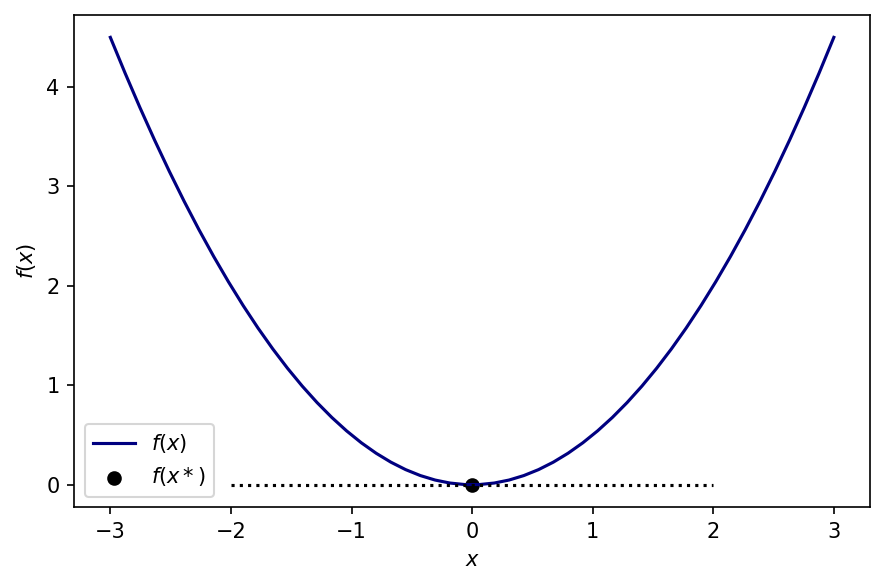

In [4]:
x = np.linspace(-3, 3)
f = lambda x: x ** 2 / 2
slope = lambda x: 2 * x

#Define tangent line
def tan_line(x, x0):
    return slope(x0) * (x - x0) + f(x0)

phi = f(x)

fig, ax = plt.subplots(figsize=[6, 4], dpi=150)

ax.plot(x, phi, color="navy", label=r"$f(x)$")

x0 = np.array([0])
line_x0 = np.array([-2, 2]) + x0
ax.scatter(x0, f(x0), label=r"$f(x*)$", color="black")
ax.plot(line_x0, tan_line(line_x0, x0), color="black", linestyle=":")

ax.legend()

ax.set_xlabel(r"$x$")
ax.set_ylabel(r"$f(x)$")

plt.tight_layout()

plt.show()

In [5]:
#Defining the objective function
def obj_fun(x):

    return (x[0] - 0.5) ** 2 + 0.7 * x[0] * x[1] + 1.2 * (x[1] + 0.7) ** 2

#Defining the gradient function
def gradient_fun(x):

    return np.array([2 * (x[0] - 0.5) + 0.7 * x[1], 0.7 * x[0] + 2 * 1.2 * (x[1] + 0.7)])

#Defining the Hessian function
def hess_fun(x):

    return np.array([[2., 0.7],
                     [0.7, 2. * 1.2]])


In [6]:
true_optima = - np.linalg.solve(hess_fun([0, 0]), gradient_fun([0, 0]))
print(true_optima)

[ 0.82969838 -0.94199536]
